# Assignment 0
## Download and study the E-coli dataset.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

If we open the dataset in notepad, we can see that the dataset looks like this:
```
AAT_ECOLI   0.49  0.29  0.48  0.50  0.56  0.24  0.35   cp
ACEA_ECOLI  0.07  0.40  0.48  0.50  0.54  0.35  0.44   cp
ACEK_ECOLI  0.56  0.40  0.48  0.50  0.49  0.37  0.46   cp
```
We have no headers and the delimiter are white spaces. In the `ecoli.names` file, we find the attributes are
  1.  **Sequence Name**: Accession number for the SWISS-PROT database
  2.  **mcg**: McGeoch's method for signal sequence recognition.
  3.  **gvh**: von Heijne's method for signal sequence recognition.
  4.  **lip**: von Heijne's Signal Peptidase II consensus sequence score. Binary attribute.
  5.  **chg**: Presence of charge on N-terminus of predicted lipoproteins. Binary attribute.
  6.  **aac**: score of discriminant analysis of the amino acid content of outer membrane and periplasmic proteins.
  7. **alm1**: score of the ALOM membrane spanning region prediction program.
  8. **alm2**: score of ALOM program after excluding putative cleavable signal regions from the sequence.
  
Finally, the last column is the target.

In [2]:
df = pd.read_table('ecoli.data', delim_whitespace = True, header = None)
df.columns = ['seqname', 'mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2', 'target']
df.head()

,seqname,mcg,gvh,lip,chg,aac,alm1,alm2,target
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp


In [3]:
# Get a sense of the distribution of the target variables
df.target.value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: target, dtype: int64

We see that imS and imL have only two values in this dataset. Therefore, we have to be careful when we predict these values. We can consider removing them from the dataset since we cannot test how accurate we are for these predictions. This is exactly what we do. We delete these targets.

We will also remove the sequence name, since we only want to use numerical values.

In [4]:
df_reduced = df[~((df.target == 'imS') | (df.target == 'imL'))].drop('seqname', axis = 'columns')
print('Length original: ', len(df))
print('Length recuced: ', len(df_reduced))

Length original:  336
Length recuced:  332


## Program a Naive Bayes classifier using sklearn to predict the location of a protein in a cell, given the characteristics described in the dataset. (criterium 2)

We create a basic NB model with all the attributes. We also choose 0.4 as our test size since we need sufficient datapoints to test our model, and we only have 332 data points. This is a matter of preference.

In [5]:
train, test = train_test_split(df_reduced, test_size = 0.4, random_state=2) 

In [6]:
X_train = train.drop('target', axis = 'columns')
y_train = train.target
clf = GaussianNB()
clf.fit(X_train, y_train)

GaussianNB()

## Evaluate the quality of the model you have created. (criterium 3)

In [7]:
labels = df.target.value_counts().index

X_test = test.drop('target', axis = 'columns')
y_test = test.target
y_pred = clf.predict(X_test)
print(f'Accuracy = {accuracy_score(y_test, y_pred)*100:.2f}%')

Accuracy = 82.71%


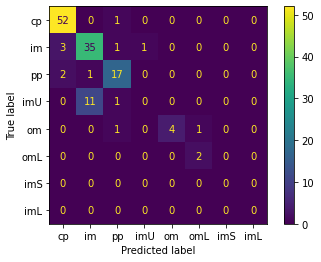

In [8]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels = labels)

We get an accuracy of 82.71%, which seems okay. But when we plot the Confusion matrix, we see that a lot of mistakes happen in one particular class: imU. This is because this class is almost never predicted.

## Consider the problem of accuracy as an evaluation criterion for this dataset and work out a possible solution/improvement. (criterium 3)


## Describe whether the data satisfies the naive Naive Bayes assumption. Substantiate this with statistical methods from previous years. (criterium 1)
The Naive Bayes assumptions are
1. Attributes are conditional independent given the class
2. In Gaussian NB, all variables follow a normal distribution.

We can use normal distribution tests (like shapiro-wilk or probabilityplots) to assess normality. Then in ChatGPT, I asked how to check the first assumption when my variables are normal distributed (if they are not normal distributed, I cannot use them anyways). The solution is
1. Stratify your data: split the dataset into subsets for each class
2. Use a statistical test like Pearson's $r$
3. Visualise with a pairplot to confirm

In [10]:
import scipy.stats as st

### Testing normality 

C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\scipy\stats\morestats.py:1757: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "
C:\ProgramData\Anaconda3\envs\ML\lib\site-packages\s

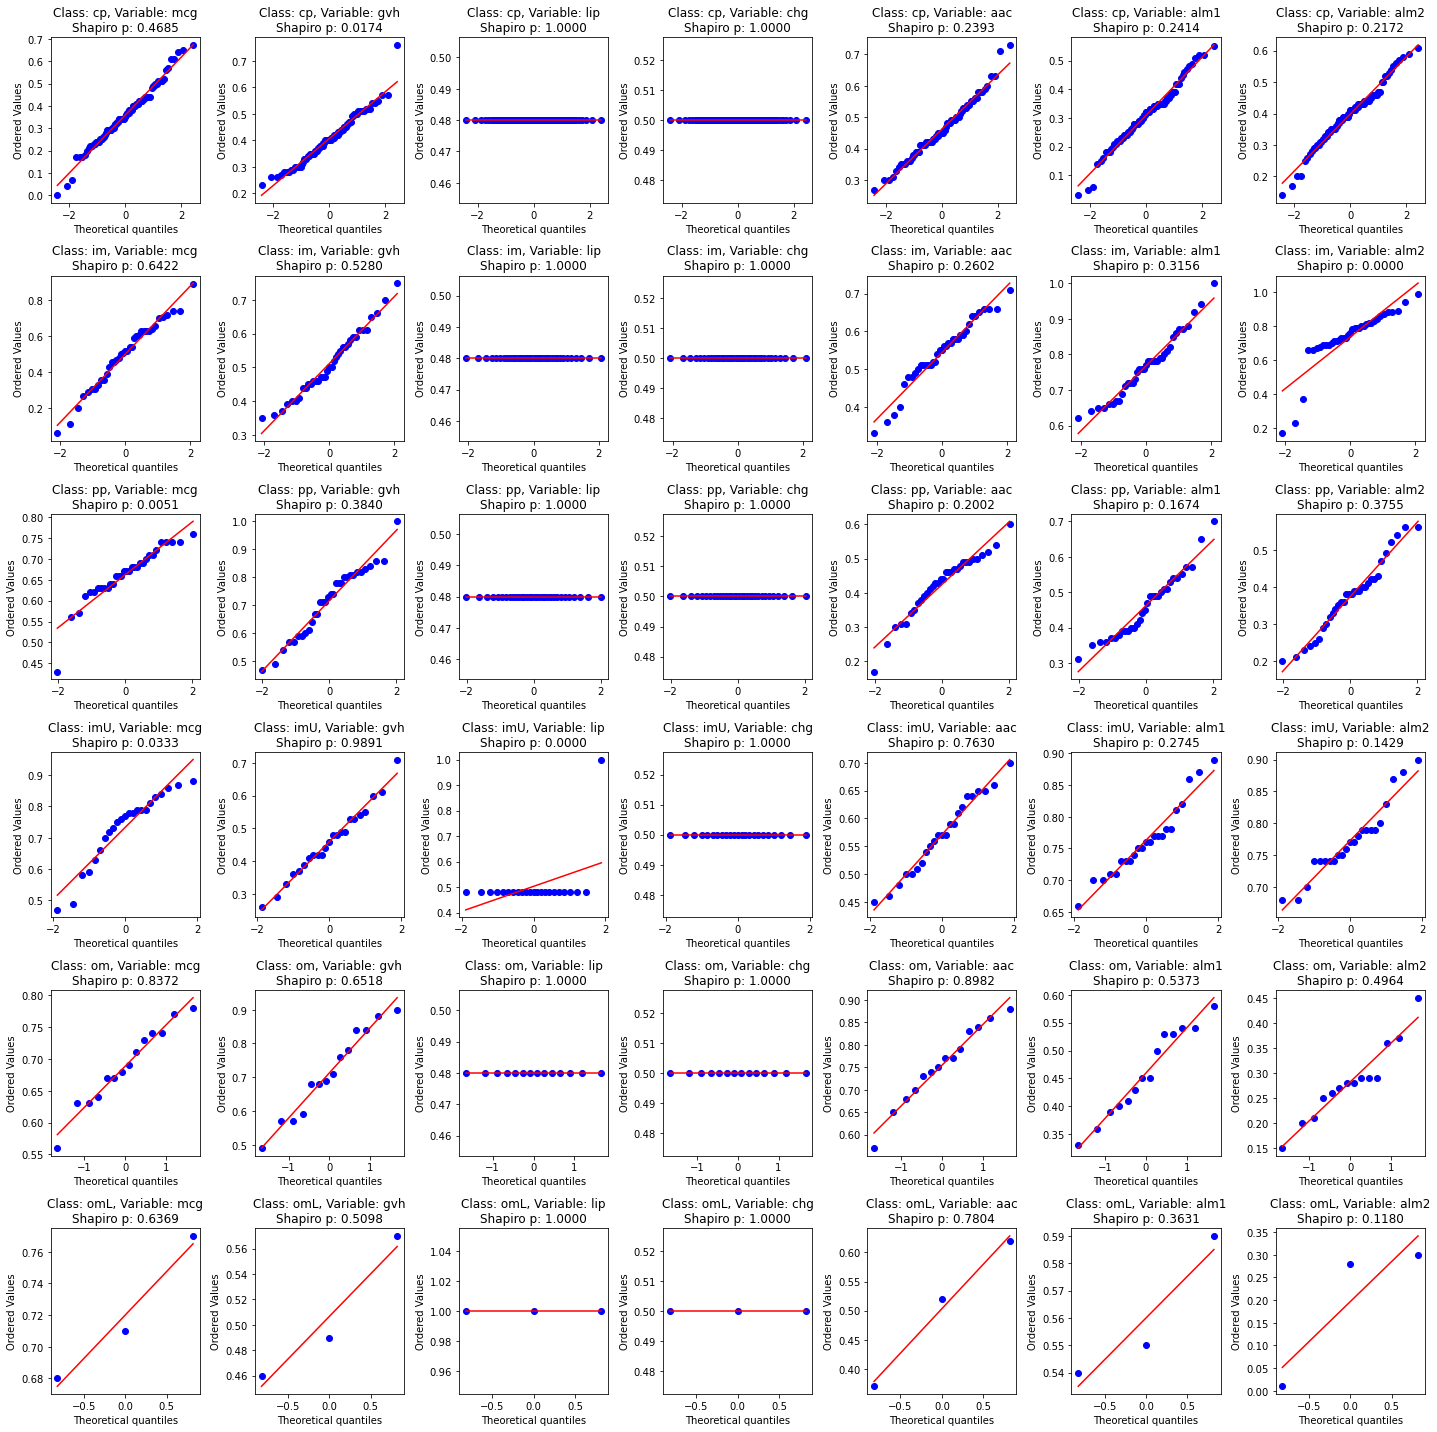

In [11]:
# Note: we only use the train data since we want to avoid data leakage.
stratified_data = {c: X_train[train.target == c] for c in train.target.unique()}

# Normality checks
C = train.target.nunique() # number of classes
k = X_train.shape[1] # number of variables
fig, ax = plt.subplots(nrows = C, ncols = k, figsize = (20, 20))
for c_idx, c in enumerate(labels[:-2]): # we dont want to test for the two classes we removed
    tempdata = stratified_data[c]
    for i in range(k):
        _, p = st.shapiro(tempdata.iloc[:, i])
        st.probplot(tempdata.iloc[:, i], plot=ax[c_idx][i]) 
        ax[c_idx][i].set_title(f'Class: {c}, Variable: {X_train.columns[i]}\nShapiro p: {p:.4f}')
        
fig.tight_layout()

# What are your conclusions?
Write your conclusions here.

In [28]:
# remove lip and chg
train_new = train[train.target != 'omL'].drop(['lip', 'chg'], axis = 'columns')
X_train_new = train_new.drop('target', axis = 'columns')

test_new = test[test.target != 'omL'].drop(['lip', 'chg'], axis = 'columns')
X_test_new = train_new.drop('target', axis = 'columns')

### Testing independence
We use the Pearson's $r$ hypothesis test:
$$H_0:\, r = 0 \quad H_1:\, r\ne 0$$

In [29]:
import seaborn as sns

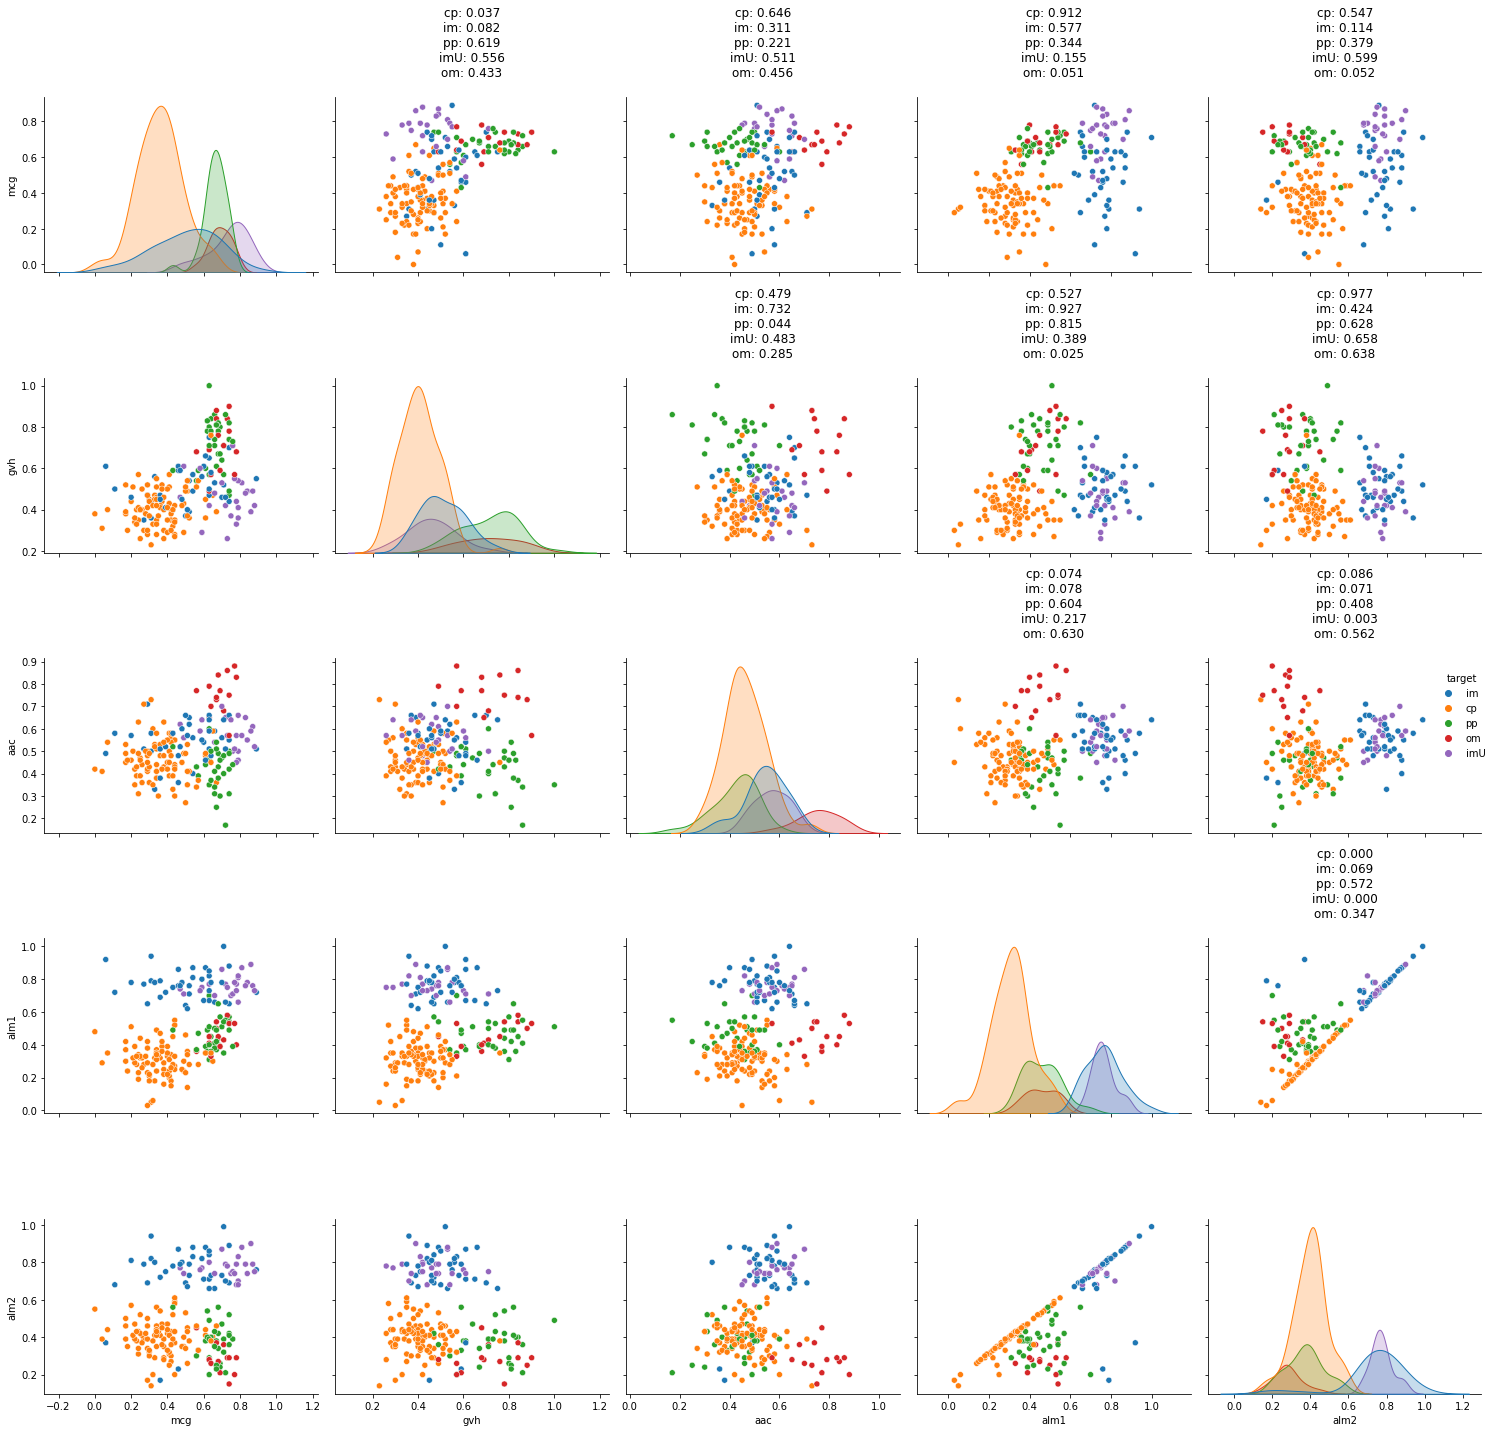

In [30]:
snsax = sns.pairplot(train_new, hue = 'target', height = 4)
stratified_data = {c: X_train_new[train_new.target == c] for c in train_new.target.unique()}

ax = snsax.axes
k = X_train_new.shape[1]
for i in range(k-1):
    for j in range(i+1, k):
        title = ''
        for c_idx, c in enumerate(labels[:-3]):
            tempdata = stratified_data[c]
            _, p = st.pearsonr(tempdata.iloc[:, i], tempdata.iloc[:, j])
            title += f'{c}: {p:.3f}\n'
        ax[i][j].set_title(title)
        
snsax.fig.tight_layout()

# What are your conclusions:
Write your conclusions here.

In [31]:
def replace_targets(df, keep_vars):
    dfnew = df.copy()
    replace_idx = ~dfnew.target.isin(keep_vars)
    dfnew.loc[replace_idx, 'target'] = 'other'
    return dfnew

In [34]:
train_cp_im = replace_targets(train_new, ['cp', 'im'])
train_cp_im.drop(['mcg', 'aac', 'alm2'], axis = 'columns', inplace = True)

train_pp = replace_targets(train_new, ['pp'])
train_pp.drop(['aac'], axis = 'columns', inplace = True)

train_imU_om = replace_targets(train_new, ['imU', 'om'])
train_imU_om.drop(['alm1', 'alm2'], axis = 'columns', inplace = True)

In [35]:
model1 = GaussianNB()
model2 = GaussianNB()
model3 = GaussianNB()

model1.fit(train_cp_im.drop('target', axis = 'columns'), train_cp_im.target)
model2.fit(train_pp.drop('target', axis = 'columns'), train_pp.target)
model3.fit(train_imU_om.drop('target', axis = 'columns'), train_imU_om.target)

GaussianNB()

We now make predictions and use the probabilities to determine which class has the highest probability. First we make a prediction function for each model. Then we concatenate all the probabilities and discard the 'other' class. And our final prediction is the prediction with the highest probability.

In [36]:
def pred_cp_im(X, model):
    cols = ['gvh', 'alm1']
    pred = model.predict(X.loc[:, cols])
    prob = model.predict_proba(X.loc[:, cols])
    return pred, prob

def pred_pp(X, model):
    cols = ['mcg', 'gvh', 'alm1', 'alm2']
    pred = model.predict(X.loc[:, cols])
    prob = model.predict_proba(X.loc[:, cols])
    return pred, prob

def pred_imU_om(X, model):
    cols = ['mcg', 'gvh', 'aac']
    pred = model.predict(X.loc[:, cols])
    prob = model.predict_proba(X.loc[:, cols])
    return pred, prob

In [1]:
m1_probs = pred_cp_im(test_new, model1)[1]
m2_probs = pred_pp(test_new, model2)[1]
m3_probs = pred_imU_om(test_new, model3)[1]

# Write the code to concat all the probabilities

NameError: name 'pred_cp_im' is not defined

In [38]:
print(classification_report(test_new.target, y_pred, labels=labels, zero_division=0))

              precision    recall  f1-score   support

          cp       0.91      0.98      0.95        53
          im       0.80      0.93      0.86        40
          pp       0.80      0.80      0.80        20
         imU       0.80      0.33      0.47        12
          om       1.00      0.50      0.67         6
         omL       0.00      0.00      0.00         0
         imS       0.00      0.00      0.00         0
         imL       0.00      0.00      0.00         0

   micro avg       0.85      0.85      0.85       131
   macro avg       0.54      0.44      0.47       131
weighted avg       0.86      0.85      0.84       131



# Compare the classification report. What are your conclusions?
Write your conclusions here.

Note: most of the conclusions based on accuracy are false. It is incorrect to use one accuracy to measure the performance (as discussed above) and therefore should not be used.

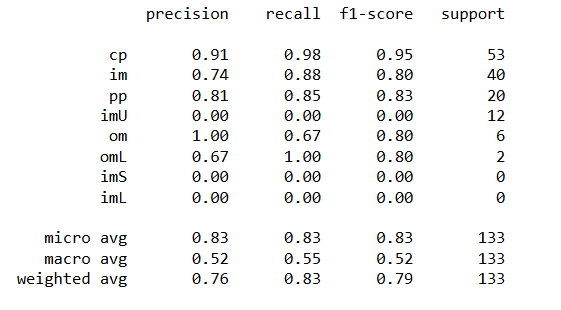

# AI use:
1. I used LanguageTool (AI assistant for writing) to check spell mistakes in the markdown cells.
2. Asked how to check conditional independence for normal variables in a naive bayes model.